## 1. Loading and Preparing the MNIST Dataset
- Normalize pixel values
- Reshape for CNN input


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape images for CNN input (add channel dimension)
# MNIST is grayscale, so channels=1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 2. Adding Noise to the Images
- Gaussian noise
- Salt & Pepper noise
- Speckle noise

In [ ]:
import numpy as np

def add_gaussian_noise(images, mean=0.0, std=0.2):
    noise = np.random.normal(loc=mean, scale=std, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Ensure pixel range is valid
    return noisy_images

def add_speckle_noise(image):
  gauss = np.random.normal(0, 1, image.shape)
  noisy = image + image * gauss
  # Clip the values to ensure they remain in [0, 1]
  noisy = np.clip(noisy, 0, 1)
  return noisy.astype(np.float32)

def add_salt_and_pepper_noise(image, amount=0.2, salt_vs_pepper=0.2):
    noisy = np.copy(image)
    total_pixels = image.size
    num_noisy = int(amount * total_pixels)

    # Salt noise
    num_salt = int(num_noisy * salt_vs_pepper)
    coords_salt = (np.random.randint(0, image.shape[0], num_salt),
                   np.random.randint(0, image.shape[1], num_salt))
    noisy[coords_salt] = 1.0

    # Pepper noise
    num_pepper = num_noisy - num_salt
    coords_pepper = (np.random.randint(0, image.shape[0], num_pepper),
                     np.random.randint(0, image.shape[1], num_pepper))
    noisy[coords_pepper] = 0.0

    return noisy

In [ ]:
import random

def apply_random_noise(img):
    noise_funcs = [add_gaussian_noise, add_salt_and_pepper_noise, add_speckle_noise]
    num_to_apply = random.randint(1, 3)
    funcs_to_apply = random.sample(noise_funcs, num_to_apply)

    for func in funcs_to_apply:
        img = func(img)
    return img

clean_img_train=x_train
clean_img_test=x_test
x_train_noisy = np.array([apply_random_noise(img) for img in x_train])
x_test_noisy = np.array([apply_random_noise(img) for img in x_test])

Examples of Original vs Noisy Images:


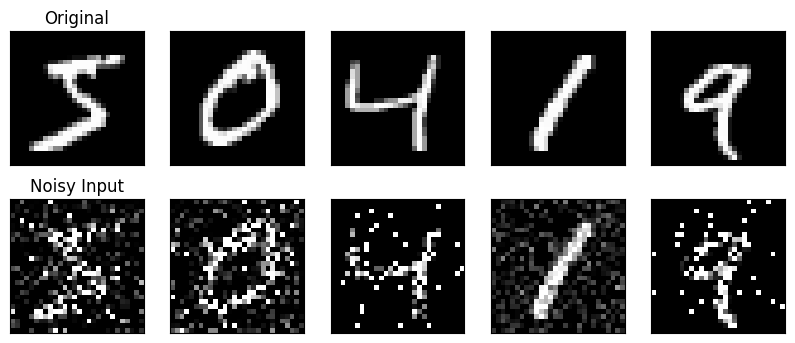

In [ ]:
# Display some noisy images
n = 5
plt.figure(figsize=(10, 4))
print("Examples of Original vs Noisy Images:")
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(clean_img_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")

    # Display noisy version
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
         ax.set_title("Noisy Input")
plt.show()


## 3. Building the Convolutional Autoencoder
- Encoder: Conv2D + ReLU + MaxPooling
- Decoder: Conv2D + UpSampling


In [ ]:
input_img = Input(shape=(28, 28, 1))

# --- Encoder ---
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Output: 14x14x32

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Output: 7x7x64 (Encoded Representation)

# --- Decoder ---
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x) # Output: 14x14x64

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x) # Output: 28x28x32

# Final Convolution to reconstruct the image
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Output: 28x28x1, Sigmoid for [0,1] pixel values

## 4. Compiling and Training the Model
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam


In [ ]:
# Create the autoencoder model
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,265 (294.00 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history=autoencoder.fit(x_train_noisy, x_train, # Train on noisy input, target clean output
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test), # Validate on noisy test data
                          verbose=1)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 222s 462ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 260s 459ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 216s 461ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 256s 450ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 264s 455ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 265s 461ms/step - loss: 0.0098 - val_loss: 0.0106
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 463ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 257s 451ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 453ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 265s 459ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 451ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 12

## 5. Denoising Results: Noisy vs Restored Images
- Visual comparison between input and output


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


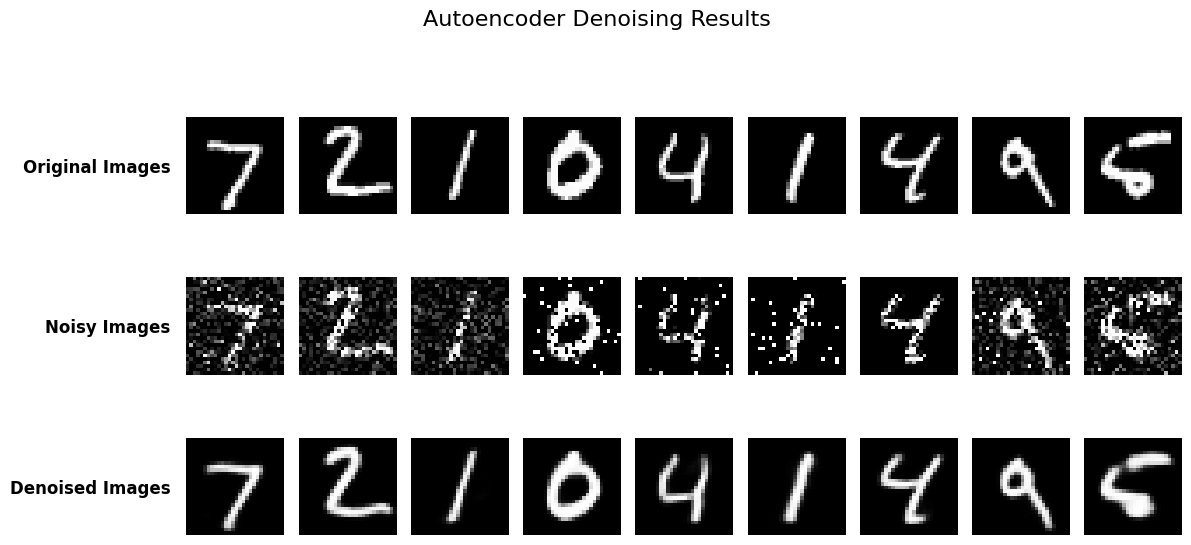


Final Test MSE Loss: 0.009353


In [ ]:
import matplotlib.pyplot as plt

# Predict (denoise) on the test set
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 9  # Number of images to display
fig, axes = plt.subplots(3, n, figsize=(12, 6))
fig.suptitle("Autoencoder Denoising Results", fontsize=16)

row_labels = ["Original Images", "Noisy Images", "Denoised Images"]

for row in range(3):
    for col in range(n):
        if row == 0:
            axes[row, col].imshow(x_test[col].reshape(28, 28), cmap='gray')
        elif row == 1:
            axes[row, col].imshow(x_test_noisy[col].reshape(28, 28), cmap='gray')
        else:
            axes[row, col].imshow(decoded_imgs[col].reshape(28, 28), cmap='gray')

        axes[row, col].axis('off')

    # Add row label on the left side of the first image in each row
    axes[row, 0].text(-5, 14, row_labels[row], va='center', ha='right',
                      fontsize=12, fontweight='bold', transform=axes[row, 0].transData)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# Evaluate final performance
loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print(f"\nFinal Test MSE Loss: {loss:.6f}")


## 6. Visualizing Training Loss


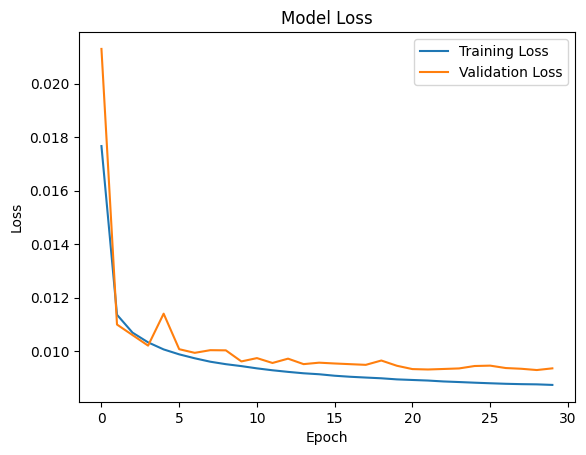

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Final Notes
This notebook demonstrates how a convolutional autoencoder  
can learn to remove various types of noise from grayscale images.

To reproduce these results, simply run the notebook on Google Colab.
